# Opdracht 3: Bepalen van muziekgenres

Gemaakt door de Music Masters:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>


# Inhoudsopgave

- [Hoofdstuk 1: Importeren van Libraries en Modules](#hoofdstuk-1-importeren-van-libraries-en-modules)

- [Hoofdstuk 2: Feature Engineering](#hoofdstuk-2-feature-engineering)
   - [2.1: Feature engineering class aanmaken](#21-feature-engineering-class-aanmaken)
   - [2.2: Feature engineering functies](#22-feature-engineering-functies)
   - [2.3: Toelichting features](#23-toelichting-features)
   - [2.4: Dataframe scalen](#24-dataframe-scalen)

- [Hoofdstuk 3: Unsupervised Learning](#hoofdstuk-3-unsupervised-learning)
   - [3.1 Clustering](#31-clustering)
   - [3.2: Bepalen van Genres](#32-bepalen-van-genres)
   - [3.3: Principal Component Analysis](#33-principal-component-analysis)
   - [3.4: Non-negative matrix factorization](#34-non-negative-matrix-factorization)
   - [3.5: Dimensionality Reduction](#35-dimensionality-reduction)
   - [3.6: Aanbevelingsapp](#36-aanbevelingsapp)

- [Hoofdstuk 4: Bevindingen en Conclusie](#hoofdstuk-4-bevindingen-en-conclusie)
   - [4.1 Bevindingen](#41-bevindingen)
   - [4.2 Conclusie](#42-conclusie)

- [Hoofdstuk 5: Referentielijst](#hoofdstuk-5-referentielijst)



<a name="hoofdstuk-1-importeren-van-libraries-en-modules"></a>
# Hoofdstuk 1: Importeren van Libraries en Modules

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pydub import AudioSegment

import IPython.display as ipd
from IPython.display import display

import librosa as lr
from librosa import load as lr_load
from librosa import amplitude_to_db
from librosa.feature import melspectrogram, mfcc, chroma_stft, spectral_flatness, zero_crossing_rate, tempogram
from librosa.beat import tempo, beat_track
from librosa.feature import spectral_contrast as lf_spectral_contrast
from librosa.feature import spectral_rolloff as lf_spectral_rolloff
from librosa import pyin, amplitude_to_db

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MeanShift
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from scipy.io import wavfile
from scipy.spatial.distance import euclidean, cityblock

D:\Programmas\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


<a name="hoofdstuk-2-feature-engineering"></a>
# Hoofdstuk 2: Feature Engineering

<a name="21-feature-engineering-class-aanmaken"></a> 
## 2.1: Feature engineering class aanmaken


In [3]:
class AudioFeatureExtractor:
    """
    A class for extracting various audio features from an audio signal.

    Attributes:
        None

    Methods:
        mfccs(data, sfreq):
            Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        calculate_spectrograms(audio_clips, n_fft=2048, hop_length=512, win_length=None):
            Calculates spectrograms from a list of audio clips.

        calculate_spectral_features(spectrograms):
            Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral contrast from the audio signal.

        calculate_tonnetz(data, sr):
            Calculates tonnetz features from the audio signal.

        calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
            Calculates spectral rolloff from the audio signal.

        calculate_chroma_features(data, sr, n_fft=2048, hop_length=512):
            Calculates chroma features from the audio signal.

        calculate_mel_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
            Calculates mel spectrogram and its contrast from the audio signal.

        calculate_spectral_flatness(data, sr, n_fft=2048, hop_length=512):
            Calculates spectral flatness from the audio signal.

        zero_crossing_rate_features(data, n_fft=2048, hop_length=512):
            Calculates zero-crossing rate from the audio signal.

        rms_energy_features(data):
            Calculates root mean square (RMS) energy from the audio signal.
    """

    def __init__(self):
        pass

    def mfccs(self, data, sr):
        """
        Extracts Mel-Frequency Cepstral Coefficients (MFCCs) from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            dict: A dictionary containing the mean of each MFCC coefficient.
        """
        mfcc_result = mfcc(y=data, sr=sr)
        datadict = {}
        for var in range(len(mfcc_result)):
            datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc_result[var, :])
        return datadict

    def calculate_spectrograms(self, audio_clips, n_fft=2048, hop_length=512, win_length=None):
        """
        Calculates spectrograms from a list of audio clips.

        Parameters:
            audio_clips (list): List of audio clips.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.
            win_length (int): The length of the windowing segments.

        Returns:
            tuple: Two lists - spectrograms and their corresponding dB-scaled versions.
        """
        spectrograms = []
        spectrograms_db = []

        for clip in audio_clips:
            stft_matrix = lr.stft(y=clip, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
            spectrogram = np.abs(stft_matrix)
            spec_db = amplitude_to_db(S=spectrogram, ref=np.max)
            spectrograms.append(spectrogram)
            spectrograms_db.append(spec_db)
        return spectrograms, spectrograms_db

    def calculate_spectral_features(self, spectrograms):
        """
        Calculates spectral features (bandwidth and centroid) from a list of spectrograms.

        Parameters:
            spectrograms (list): List of spectrograms.

        Returns:
            tuple: Two lists - spectral bandwidths and centroids.
        """
        bandwidths = []
        centroids = []

        for spectrogram in spectrograms:
            spec_bw = lr.feature.spectral_bandwidth(S=spectrogram)
            spec_cn = lr.feature.spectral_centroid(S=spectrogram)
            bandwidths.append(spec_bw)
            centroids.append(spec_cn)
        return bandwidths, centroids

    def calculate_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral contrast features.
        """
        datadict = {}
        spectral_contrast = lr.feature.spectral_contrast(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        for var in range(len(spectral_contrast)):
            datadict[f'spectral_contrast{var + 1}_mean'] = np.mean(spectral_contrast[var, :])
        return datadict

    def calculate_tonnetz(self, data, sr):
        """
        Calculates tonnetz features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.

        Returns:
            numpy.ndarray: Tonnetz features.
        """
        tonnetz = lr.feature.tonnetz(y=data, sr=sr)
        datadict = {}
        for var in range(len(tonnetz)):
            datadict[f'tonnetz{var + 1}_mean'] = np.mean(tonnetz[var, :])
        return datadict

    def calculate_spectral_rolloff(self, data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
        """
        Calculates spectral rolloff from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            roll_percent (float): Percentage for determining rolloff.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral rolloff features.
        """
        spectral_rolloff = lr.feature.spectral_rolloff(y=data, sr=sr, roll_percent=roll_percent, n_fft=n_fft, hop_length=hop_length)
        return spectral_rolloff

    def calculate_chroma_features(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates chroma features from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Chroma features.
        """
        chromagram = chroma_stft(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        datadict = {}
        for var in range(len(chromagram)):
            datadict[f'chromagram{var + 1}_mean'] = np.mean(chromagram[var, :])
        return datadict

    def calculate_mel_spectral_contrast(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates mel spectrogram and its contrast from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Mel spectrogram contrast features.
        """
        mel_spectrogram = melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length)
        mel_spectral_contrast = lr.feature.spectral_contrast(S=mel_spectrogram)
        datadict = {}
        for var in range(len(mel_spectral_contrast)):
            datadict[f'mel_spectral_contrast{var + 1}_mean'] = np.mean(mel_spectral_contrast[var, :])
        return datadict

    def calculate_spectral_flatness(self, data, sr, n_fft=2048, hop_length=512):
        """
        Calculates spectral flatness from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            sr (int): The sampling rate of the audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Spectral flatness features.
        """
        flatness = lr.feature.spectral_flatness(y=data, n_fft=n_fft, hop_length=hop_length)
        return flatness

    def zero_crossing_rate_features(self, data, n_fft=2048, hop_length=512):
        """
        Calculates zero-crossing rate from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.
            n_fft (int): The number of points for each FFT.
            hop_length (int): The number of samples between successive frames.

        Returns:
            numpy.ndarray: Zero-crossing rate features.
        """
        zcr = zero_crossing_rate(y=data, frame_length=n_fft, hop_length=hop_length)
        return zcr

    def rms_energy_features(self, data):
        """
        Calculates root mean square (RMS) energy from the audio signal.

        Parameters:
            data (numpy.ndarray): The audio signal.

        Returns:
            numpy.ndarray: RMS energy features.
        """
        rms_energy = lr.feature.rms(y=data)[0]
        return rms_energy

<a name="22-feature-engineering-functies"></a> 
## 2.2: Feature engineering functies

In [4]:
csv_path = "labels_new.csv"
audio_directory_labeled = "labeled"
audio_directory_unlabeled = "unlabeled"

audio_extractor = AudioFeatureExtractor()
# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)

def process_audio_features(audio_directory, labeled=True, df=df):
    # Audio features storage
    audio_features_list = []

    # Set the target length for audio truncation or padding
    lengte = 30 * 22050

    audio_arrays = np.empty((len(os.listdir(audio_directory)), lengte))
    # Process each audio file
    for index, file in enumerate(os.listdir(audio_directory)):
        sr = lr.get_samplerate(f'{audio_directory}/{file}')
        if file.endswith(".wav"):
            # sr = lr.get_samplerate(file)
            file_path = os.path.join(audio_directory, file)
            data, sfreq = lr.load(file_path, sr=None)
            # Truncate or pad the audio
            if len(data) > lengte:
                # Truncate the data
                data = data[:lengte]
            elif len(data) < lengte:
                # Pad with zeros
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')
            
            audio_arrays[index] = data
            
            # Extract MFCC features
            mfcc_features = audio_extractor.mfccs(data, sfreq)
            spectral_contrast_features = audio_extractor.calculate_spectral_contrast(data, sr)
            tonnetz_features = audio_extractor.calculate_tonnetz(data, sr)
            spectral_rolloff_feature = audio_extractor.calculate_spectral_rolloff(data, sr)
            chroma_features = audio_extractor.calculate_chroma_features(data, sr)
            mel_spectral_contrast_features = audio_extractor.calculate_mel_spectral_contrast(data, sr)
            spectral_flatness_feature = audio_extractor.calculate_spectral_flatness(data, sr)
            zero_crossing_feature = audio_extractor.zero_crossing_rate_features(data)
            rms_energy = audio_extractor.rms_energy_features(data)
            
       # Combine all features into a dictionary
            features_dict = {
                'filename': file, 
                **mfcc_features,
                'rms_energy': np.mean(rms_energy),
                **spectral_contrast_features,
                **tonnetz_features,
                'spectral_rolloff': np.mean(spectral_rolloff_feature[0]),
                **chroma_features,
                **mel_spectral_contrast_features,
                'spectral_flatness': np.mean(spectral_flatness_feature[0]),
                'zcr': np.mean(zero_crossing_feature[0])
            }
                # Append the features dictionary to the list
            audio_features_list.append(features_dict) 
            
    spectograms, spectogram_features = audio_extractor.calculate_spectrograms(audio_arrays)
    bandwidths, centroids = audio_extractor.calculate_spectral_features(spectograms)

    bandwiths = pd.DataFrame({'bandwith': [np.mean(bandwidth[0]) for bandwidth in bandwidths]})
    centroids = pd.DataFrame({'centroid': [np.mean(centroid[0]) for centroid in centroids]})
    # Convert the list of feature dictionaries to a DataFrame
    audio_features_df = pd.DataFrame(audio_features_list)
    audio_features_df = pd.concat([audio_features_df, bandwiths], axis=1)
    audio_features_df = pd.concat([audio_features_df, centroids], axis=1)
    # Merge the original DataFrame with the new features DataFrame based on the 'filename' column
    if labeled:
        audio_features_df = pd.merge(df, audio_features_df, on='filename', how='left')

    audio_features_df = audio_features_df.sort_values(by='filename')
    return audio_features_df

# Process audio features
labeled_df = process_audio_features(audio_directory_labeled)
display(labeled_df)

unlabeled_df = process_audio_features(audio_directory_unlabeled, labeled=False)
display(unlabeled_df)

,filename,genre,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
8,m00002.wav,jazz,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,12.746783,...,6.739004,17.720329,31.856210,37.582171,36.234603,42.188262,0.001252,0.051222,1919.917650,1451.498371
9,m00039.wav,reggae,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,13.026835,...,8.001072,15.869485,22.225069,29.004593,27.931632,43.075836,0.004306,0.072178,2019.252686,1811.358216
43,m00041.wav,pop,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,-0.249471,...,5.718698,13.057337,17.657730,23.827369,27.071292,18.570913,0.078506,0.152910,2992.192112,3111.061099
29,m00072.wav,disco,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,4.690686,...,6.370224,12.197484,18.810620,25.720595,24.686535,23.377385,0.038270,0.120259,2709.990169,2625.095044
34,m00096.wav,disco,-91.886307,87.604057,-2.058175,34.285538,-18.153370,19.344702,-14.697328,17.116173,...,4.989545,15.582052,20.384724,25.294628,29.771765,46.579813,0.009796,0.115890,2486.020650,2550.135384
48,m00102.wav,classical,-436.842285,154.113205,-19.859337,20.183603,3.164744,0.446392,-6.530639,-4.603339,...,8.704671,18.088766,26.164080,36.452103,37.462534,35.556624,0.000976,0.066325,1517.856160,1173.931066
25,m00112.wav,reggae,-265.694977,80.615921,9.722022,36.657085,27.836796,12.086828,15.014478,15.116937,...,3.927251,15.154408,20.473471,26.257647,25.445807,24.486615,0.026549,0.060883,2595.217468,2113.391953
4,m00138.wav,reggae,-198.632797,102.413582,-10.031449,30.802383,-3.310606,20.276924,-5.637373,28.095631,...,8.111595,11.985461,21.690643,26.647311,26.212014,47.129611,0.005168,0.070323,2295.466240,1995.600514
5,m00192.wav,classical,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922598,-10.950942,-1.620085,...,5.707315,9.457773,16.339001,23.798978,26.500622,37.537164,0.010484,0.111613,1965.028715,1878.774030
22,m00206.wav,hiphop,-92.591652,77.412682,-32.756371,54.596119,-13.199195,33.656281,-12.085772,28.015388,...,3.856905,11.629413,12.605242,16.697020,17.101189,52.441041,0.018014,0.157603,2295.456105,2735.795802


,filename,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
0,m00003.wav,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,-19.003857,...,5.011253,13.892055,18.007974,21.183092,21.028454,58.034254,0.009073,0.120159,2070.908728,2254.451748
1,m00012.wav,-1.925411,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,-11.945406,...,6.322091,13.544996,16.113373,22.568365,18.241123,55.859046,0.026390,0.178119,2286.246872,2908.260266
2,m00013.wav,-287.520996,101.737930,-35.368999,41.282764,-12.745123,17.284992,-13.978299,16.311886,-5.599029,...,4.346955,16.482222,24.210026,32.560252,34.102601,59.447519,0.002209,0.123492,1865.851544,1953.012399
3,m00043.wav,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123723,23.654572,-14.638494,...,4.574703,13.135090,15.795038,18.074718,19.134837,60.384606,0.008840,0.126103,2073.302486,2384.812610
4,m00044.wav,-437.525208,170.971405,7.386171,-3.108705,0.777302,-11.135056,-12.523807,-6.900928,-5.850053,...,4.602050,18.591778,23.050981,33.758989,36.850383,40.763202,0.000153,0.052112,899.979779,790.478225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,m00971.wav,-246.218369,149.443878,-41.973816,11.606413,-10.287585,-4.018404,-7.138945,-10.137027,-9.425965,...,6.321750,12.820653,17.553917,24.904399,30.941367,37.337512,0.006206,0.091588,1588.161024,1525.601266
101,m00973.wav,-8.531343,54.251755,20.963310,13.099079,9.721153,6.015052,10.720785,6.102119,0.694264,...,7.653338,10.039850,19.457696,25.698457,25.316437,18.259208,0.088824,0.161897,3295.553789,3671.260489
102,m00988.wav,-56.091187,36.468166,11.945320,-6.441752,3.778163,5.284157,3.394784,4.265098,7.993917,...,6.389734,16.538572,24.927608,25.531409,23.668680,16.240189,0.089230,0.167399,3361.504206,3940.349921
103,m00991.wav,-406.965424,163.139465,-2.413809,32.456650,7.907843,9.677136,-5.489037,9.523492,-3.102817,...,8.248197,19.474204,27.322492,31.308818,33.020523,45.577339,0.000300,0.044227,1404.132189,983.761841


<a name="23-toelichting-features"></a> 
## 2.3: Toelichting features

Voor het maken van het voorspellende model hebben wij feature engineering toegepast op de labeled en unlabeled dataset. De toegevoegde features zijn hierboven te zien. Door het toepassen van feature engineering proberen wij de prestaties van ons voorspellend model te verbeteren.
Hieronder zullen wij elke toegevoegde feature toelichten.

## Mel-Frequency Cepstral Coefficients (MFCCs)

Als eerste voegen wij meerder MFCCs toe aan onze dataframe.
Dit zijn coëfficiënten die de vorm van het spectrum van geluiden beschrijven. Ze worden berekend door een Fourier-transformatie toe te passen op kleine tijdvensters van het signaal, waarna de logaritme van de amplitudes wordt genomen, gevolgd door een discrete cosinetransformatie. Het resultaat is een reeks coëfficiënten die de frequentie-inhoud van het geluid op een compacte manier weergeven.

Voor het berekenen van de MFCCs worden de volgende 5 stappen doorlopen:


### Stap 1. **Framing:**
   $ x_w[n] = x[n] \cdot w[n] $
   
Bij deze stap wordt het audio-signaal opgedeeld in kleine tijdvensters, ook wel frames genoemd. Dit helpt bij het vastleggen van de tijdsgebonden eigenschappen van het geluid. Het signaal binnen elk frame wordt vermenigvuldigd met een Hamming-vensterfunctie $ w[n] $ om abrupte overgangen aan het begin en einde van het frame te minimaliseren. Het resultaat is het venstergedragde signaal $ x_w[n] $.

### Stap 2. **Fast Fourier Transform (FFT):**
   $ X(k) = \text{FFT}(x_w[n]) $
   
Fast Fourier Transform (FFT):
Hier wordt de FFT toegepast op elk venstergedragde signaal $ x_w[n] $. Dit leidt tot de decompositie van het signaal van het tijddomein naar het frequentiedomein, waarbij de amplitudes en fasen van de frequentiecomponenten worden verkregen. De resulterende gegevens worden weergegeven als $ X(k) $, waarbij $ k $ de frequentie-index is.

### Stap 3. **Mel Filterbank:**
   $ S_m = \sum_{k=0}^{N-1} |X(k)|^2 \cdot H_m(k) $

In deze stap wordt de energie in verschillende frequentiebanden gemeten met behulp van een Mel-filterbank. Elk Mel-filter $ H_m(k) $ is ontworpen om de energie in een bepaald frequentiegebied te vertegenwoordigen volgens de Mel-schaal, die de menselijke waarneming van geluidsfrequentie weergeeft. De energie $ S_m $ in elk Mel-filter wordt berekend door de kwadraten van de magnitude van de FFT-resultaten te vermenigvuldigen met de overeenkomstige filterresponsen en deze op te tellen over alle frequentiebanden.

### Stap 4. **Logarithmic Scaling:**
   $ M_m = \log(S_m) $

Na het verkrijgen van de Mel-energieën, worden deze waarden logaritmisch geschaald. Dit wordt gedaan om de dynamische bereik van de gegevens te comprimeren en om de representatie te verbeteren, aangezien mensen logaritmische schalen beter waarnemen dan lineaire schalen. Het resultaat is een reeks logaritmisch geschaalde Mel-energieën $ M_m $.

### Stap 5. **Discrete Cosine Transform (DCT):**
   $ C_l = \sum_{m=0}^{M-1} \cos\left(\frac{\pi l (2m + 1)}{2M}\right) \cdot M_m $
   
Ten slotte worden de logaritmisch geschaalde Mel-energieën onderworpen aan de DCT. Dit proces vertaalt de gegevens van het frequentiedomein naar het cepstrale domein, waarbij de coëfficiënten $ C_l $ worden verkregen. Deze coëfficiënten representeren verschillende frequentiecomponenten van het geluidsspectrum op een compacte en gestructureerde manier.

   Gebruikte Symbolen:
   - $ x[n] $: Audio signaal.
   - $ w[n] $: Hamming window.
   - $ X(k) $: Resultaat vab de FFT.
   - $ H_m(k) $: $m$-de Mel filter.
   - $ S_m $: Energie in het $m$-de Mel filter.
   - $ M_m $: Log-Mel energie.
   - $ C_l $: $l$- de MFCC coefficient.
   - $ N $: Aantal frequentiepunten na FFT.
   - $ M $: Aantal Mel filters.
   - $ L $: Aantal gewenste MFCCs.
   
(Deruty, 2022)


## Root Mean Square energy

Vervolgens voegen wij Root Mean Square energy (RMS energy) toe. Deze feature geeft aan hoeveel energie het signaal gemiddeld bevat. Bij ons gaat het hier om het geluidssignaal van muzieknummers. Aan de hand van de RMS energy kan de intensiteit van het signaal makkelijk worden beoordeeld. Hoe hoger de RMS energy, hoe luider het signaal gemiddeld is.

Voor het berekenen van de RMS energy nemen wij de RMS van het muzieksignaal. Dit gaat als volgt:

1. Kwadrateer elk monster $ x[n] $ in het signaal:
$ x^2[n] $

2. Bereken het gemiddelde van deze gekwadrateerde monsters over de hele periode $ N $:
$ \text{Gemiddelde} = \frac{1}{N} \sum_{n=0}^{N-1} x^2[n] $

3. Neem de vierkantswortel van dit gemiddelde:
$ \text{RMS} = \sqrt{\text{Gemiddelde}} $

(Hathaway, 2005)

## Spectral  Contrast

We voegen ook spectral contrast toe, een functie die het verschil in amplitude tussen pieken en dalen in een frequentiespectrum meet. Dit biedt inzicht in het perceptuele contrast tussen spectrale pieken en achtergrondgeluid, wat informatie oplevert over de toonkwaliteit van het geluid, in ons geval over verschillende muziekfragmenten.

De waarde van spectral contrast wordt bepaald door eerst het frequentiespectrum van het geluidssignaal op te splitsen in verschillende frequentiebanden. Vervolgens wordt voor elke frequentieband het contrast berekend tussen het gemiddelde energieniveau van die band en het gemiddelde energieniveau van aangrenzende frequentiebanden. Dit contrast wordt genormaliseerd om rekening te houden met verschillen in de absolute energieniveaus van het geluidssignaal. Ten slotte worden de resulterende waarden voor elke frequentieband samengevoegd tot een enkel kenmerk dat de mate van variabiliteit in het geluidsspectrum weergeeft.

Formule spectral contrast:

$$ C_m = \sum_{k=1}^{K} \left| X(k) \right| \cdot \left| X(k) - X_{\text{min}}(k) \right| $$

waarbij:
- $ C_m $ de spectral contrast feature voor de $ m $-de frequentieband is,
- $ X(k) $ de amplitude van de $ k $-de frequentie in het spectrum is,
- $ X_{\text{min}}(k) $ de laagste amplitude in de $ m $-de frequentieband is, en
- $ K $ het aantal frequentiebanden is.


(Librosa.Feature.Spectral_Contrast — Librosa 0.10.1 Documentation, z.d.)

## Tonnetz

Tonnetz is een concept uit de muziektheorie dat de harmonische relaties tussen tonen en akkoorden visualiseert door middel van een zeshoekig rooster of diagram, vergelijkbaar met een muzikale kaart waarop de onderlinge verbanden tussen verschillende tonen en akkoorden worden weergegeven.

De waarde van Tonnetz wordt bepaald door de berekening van de afstanden tussen punten op het rooster, wat de mate van harmonische verwantschap aangeeft. Deze berekening maakt gebruik van muziektheoretische concepten, zoals toonafstanden en intervallen, om de harmonische relaties te definiëren.

Punten die dicht bij elkaar liggen op het Tonnetz-rooster vertegenwoordigen sterke harmonische verbindingen, terwijl punten die verder uit elkaar liggen minder nauw verbonden zijn harmonisch gezien. De analyse van Tonnetz biedt inzicht in de harmonische structuur en relaties binnen een muziekstuk, wat van belang kan zijn voor ons voorspellend model.

In ons project maken we gebruik van de librosa-module om de Tonnetz te bepalen. Eerst wordt het audiosignaal omgezet naar een spectrogram, waarna chromagramfuncties worden berekend. De afstanden tussen de chromagrampunten worden vervolgens omgezet naar een zeshoekig Tonnetz-rooster met behulp van een transformatiematrix die de relaties tussen noten weergeeft. Uiteindelijk kan hiermee een visuele weergave worden getoond, waardoor we de muzikale structuur en harmonische samenhang van het signaal kunnen analyseren.

Verder is er geen specifieke formule voor het berekenen van Tonnetz, omdat het een conceptueel model is dat gebaseerd is op muziektheoretische principes en geometrische representatie.

(Librosa.Feature.Tonnetz — Librosa 0.10.1 Documentation, z.d.)

## Spectral Rolloff

Het spectral rolloff is eenvoudigweg de frequentie die het frequentiegebied onder een bepaald percentage van de totale spectrale energie verdeelt, meestal is dit bij 85%. Bovendien dient het als een indicator van de mate van verandering in spectrale energie naarmate de frequentie toeneemt, waardoor het informatie verschaft over de steilheid van het spectrum van een geluidssignaal.

De formule is gegeven door:

$ R = \frac{\sum_{f} S(f)}{\sum_{f} S(f_{\text{totaal}})} \cdot 100 \leq p $

- $ R $: Spectraalverloop frequentie.
- $ S(f) $: Spectrale energie bij frequentie $ f $.
- $ S(f_{\text{totaal}}) $: Totale spectrale energie.
- $ p $: Percentage van de totale spectrale energie (bijvoorbeeld 85% of 95%).

(Librosa.Feature.Spectral_Rolloff — Librosa 0.10.1 Documentation, z.d.)

## Chroma Features

Chroma-kenmerken bieden inzicht in de toonhoogteverdeling in muziek, waarbij de tonale kwaliteiten worden benadrukt. Het chromagram, een grafische weergave van de chroma-kenmerken, deelt het muzikale octaaf op in 12 gelijke delen, die overeenkomen met de 12 muzikale toonhoogteklassen: {C, C♯, D, D♯, E, F, F♯, G, G♯, A, A♯, B}

De chroma-Features worden berekend met behulp van het chromagram, waarbij elke chromawaarde (C_i) wordt bepaald door de som van de magnitudes van de frequentiecomponenten die overeenkomen met de betreffende toonhoogteklasse. Met andere woorden, voor elke toonhoogteklasse wordt de magnitude van alle frequentiecomponenten die in die klasse vallen opgeteld.(Wikipedia contributors, 2024)

De formule om de chromawaarde $ C_i $ te berekenen is:

$ C_i = \sum_{j} \text{magnitude}(f_j) $


Hierbij staat $ C_i $ voor de chromawaarde voor de $ i $-de toonhoogteklasse, en magnitude$ \text{magnitude}(f_j) $ staat voor de magnitude van de $ j $-de frequentiecomponent in het spectrum die overeenkomt met de betreffende toonhoogteklasse. De sommatie wordt uitgevoerd over alle frequentiecomponenten die overeenkomen met de $ i $-de toonhoogteklasse.

Dit proces wordt herhaald voor elk van de twaalf toonhoogteklassen om de complete chroma-kenmerken te verkrijgen.

## Mel Spectral Contrast Features

We voegen ook Mel Spectral Contrast features toe, een functie die het verschil in amplitude tussen pieken en dalen in een frequentiespectrum meet, maar dan op basis van de Mel-schaal. Dit biedt inzicht in het perceptuele contrast tussen spectrale pieken en achtergrondgeluid, waardoor we informatie verkrijgen over de toonkwaliteit van het geluid, met name voor verschillende muziekfragmenten.

De waarde van Mel Spectral Contrast wordt bepaald door eerst het frequentiespectrum van het geluidssignaal om te zetten naar de Mel-schaal. Vervolgens wordt voor elke Mel-frequentieband het contrast berekend tussen het gemiddelde energieniveau van die band $ \mu_m $ en het gemiddelde energieniveau van aangrenzende Mel-frequentiebanden. Dit contrast wordt gewogen met het kwadraat van de afstand tot het gemiddelde $ (m - \mu_m)^2 $ en genormaliseerd om rekening te houden met verschillen in de absolute energieniveaus van het geluidssignaal. Ten slotte worden de resulterende waarden voor elke Mel-frequentieband samengevoegd tot een enkel kenmerk dat de mate van variabiliteit in het geluidsspectrum weergeeft. Dit kenmerk voegen wij uiteindelijk toe aan het dataframe.(Verma, 2021)

Formule voor mel spectral contrast:

$$
\text{Mel_Spectral_Contrast}(X) = \frac{\sum_{m=1}^{M} (m - \mu_m)^2 \cdot S_m}{\sum_{m=1}^{M} S_m}
$$

## Spectral Flatness

Spectral Flatness is een audiokenmerk dat de mate van variabiliteit in het frequentiespectrum van een geluidssignaal beschrijft. Het geeft aan hoe gelijkmatig de energie verdeeld is over de frequentiebanden in het spectrum. Een hoge waarde voor Spectral Flatness suggereert een gelijkmatige verdeling van energie over het spectrum, wat kan duiden op een geluidssignaal met een breed frequentiebereik en een gebrek aan dominante frequentiepieken. Aan de andere kant duidt een lage waarde op een sterk piekachtig spectrum, waarbij de energie geconcentreerd is rond specifieke frequenties.

De waarde van Spectral Flatness wordt berekend door de meetkundige gemiddelde (GM) te delen door het rekenkundige gemiddelde (AM) van de amplitudes van de frequentiecomponenten in het spectrum. Met andere woorden, het wordt berekend als de verhouding tussen het gemiddelde van de logaritmische amplitudes en de logaritmische amplitude van het gemiddelde. Deze verhouding wordt vaak genormaliseerd om waarden tussen 0 en 1 te krijgen, waarbij een waarde dichter bij 1 wijst op een vlakker spectrum en een waarde dichter bij 0 op een meer piekachtig spectrum.(Wikipedia contributors, 2023)

In formulevorm kan Spectral Flatness worden uitgedrukt als:
$$
\text{Spectral Flatness} = \frac{{\exp\left(\frac{1}{N} \sum_{i=1}^{N} \ln(A_i)\right)}}{{\frac{1}{N} \sum_{i=1}^{N} A_i}}
$$


Waarbij $ (A_i) $ de amplitude van de $i$-de frequentiecomponent is en $N$ het totale aantal frequentiecomponenten in het spectrum.

## Zero Crossing Rate

Zero Crossing Rate (ZCR) is een audiokenmerk dat de frequentie van signaalovergangen door nul in een geluidssignaal meet. Het houdt rekening met het aantal keren dat het signaal de horizontale as kruist en geeft daarmee een indicatie van de veranderingen in het signaal over de tijd. Een hogere ZCR duidt op meer veranderingen in het signaal en kan worden geassocieerd met geluiden met een hogere mate van dynamiek of ruwheid, wat waardevolle informatie biedt over de aard en complexiteit van het geluidssignaal.

De Zero Crossing Rate wordt berekend met behulp van de formule:

$$
\text{ZCR} = \frac{1}{N-1} \sum_{n=1}^{N-1} | \text{sign}(x[n]) - \text{sign}(x[n-1]) |
$$

Hierbij staat $ N $ voor het aantal samples in het signaal en $ x[n] $ voor de waarde van het signaal op het tijdstip $ n $. De ZCR geeft het gemiddelde aantal keren aan waarop het signaal de waarde nul kruist per tijdsinterval, wat een indicatie kan zijn van de mate van verandering of activiteit in het signaal.(Torres-García et al., 2022)

## Bandwidth

Bandbreedte, ook wel bekend als Bandwidth, refereert naar het bereik van frequenties binnen een signaal of een frequentiespectrum. Het indiceert hoeveel ruimte een signaal beslaat op de frequentieschaal en wordt uitgedrukt in hertz (Hz). Een brede bandbreedte suggereert dat het signaal een uitgebreid frequentiebereik omvat, terwijl een smalle bandbreedte aanduidt dat het signaal beperkt is tot een klein frequentiebereik.

De waarde van de bandbreedte wordt vastgesteld door het verschil te berekenen tussen de hoogste en laagste frequentiecomponenten in het signaal of frequentiespectrum. Dit kan worden uitgedrukt door de frequentie van het hoogste punt in het spectrum te verminderen met de frequentie van het laagste punt. In een frequentiespectrum wordt de bandbreedte beïnvloed door de breedte van de pieken die de energie van het signaal op verschillende frequenties weergeven. Een bredere piek duidt op een grotere bandbreedte, terwijl een smallere piek wijst op een kleinere bandbreedte.

De formule voor het berekenen van de bandbreedte $ B $ is:

$$ B = f_{\text{max}} - f_{\text{min}} $$

Waarbij $ f_{\text{max}} $ de frequentie van het hoogste punt in het spectrum vertegenwoordigt, en $ f_{\text{min}} $ de frequentie van het laagste punt in het spectrum.

## Centroids

Centroids, in de context van signaalverwerking en akoestische analyse, zijn maatstaven die worden gebruikt om de centrale frequentie van een signaal of een frequentiespectrum te kwantificeren. Het concept van een centroid komt voort uit de statistiek, waar het verwijst naar het massamiddelpunt van een geometrische vorm. 

In de context van akoestische analyse, vertegenwoordigt de centroid de gemiddelde frequentie van een geluidssignaal. Het is een belangrijk kenmerk dat informatie geeft over waar de meeste energie in het frequentiespectrum van het signaal geconcentreerd is. De centroid kan bijvoorbeeld aangeven of een geluidssignaal eerder laagfrequent (lage centroid) of hoogfrequent (hoge centroid) is.(Wikipedia contributors, 2024a)

Hieronder staat de formule voor het berekenen van de centroid.

De formule voor het berekenen van de centroid ($ C $) is:

$$ C = \frac{\sum_{i} f_i \cdot A_i}{\sum_{i} A_i} $$

- $ C $: Centroid (gemiddelde frequentie).
- $ f_i $: Frequentie van de $ i $-de component.
- $ A_i $: Amplitude (of magnitude) van de $ i $-de component.




<a name="24-dataframe-scalen"></a> 
## 2.4: Dataframe scalen

In [5]:
def scaler(df, labeled=True):
    """
    Normalizes numeric columns of a DataFrame using sklearn MinMaxScaler

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing numeric columns to be standardized.

    Returns:
    - pd.DataFrame: A new DataFrame with standardized numeric columns.
    """
    scaler = MinMaxScaler()
    if labeled:
        cols = ['filename', 'genre']
    else:
        cols = ['filename']

    scaled_df = df[df.columns.difference(cols)]
    scaled_df = pd.DataFrame(scaler.fit_transform(scaled_df))
    scaled_df.columns = df[df.columns.difference(cols)].columns
    scaled_df = pd.concat([pd.DataFrame(df[cols]), scaled_df], axis=1)
        
    return scaled_df


In [6]:
df = scaler(unlabeled_df, labeled=False)
display(df.head())

,filename,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,m00003.wav,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,m00012.wav,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,m00013.wav,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,m00043.wav,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,m00044.wav,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402056,0.456909,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807


In [7]:
df.drop("filename", axis=1, inplace=True)
df


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402056,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483318,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644380,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896679,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


<a name="hoofdstuk-3-unsupervised-learning"></a>
# Hoofdstuk 3: Unsupervised Learning

<a name="31-clustering"></a> 
## 3.1 Clustering

D:\Programmas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Programmas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Programmas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
D:\Programmas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

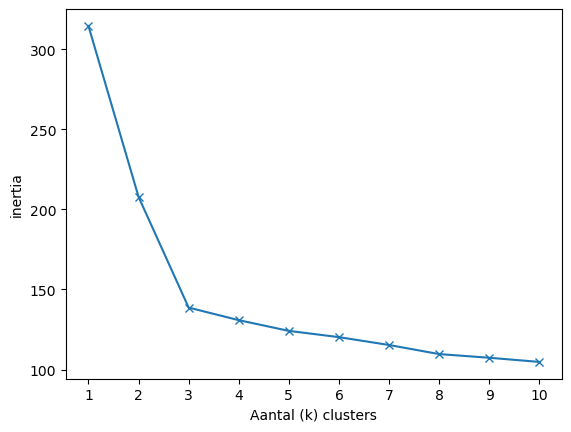

In [8]:
# overgenomen uit ml les
inertia = []
k = range(1, 11)

for i in k:
    model = KMeans(n_clusters=i, n_init=10)

    model.fit(df)

    inertia.append(model.inertia_)

plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

hier kunnen we zien dat het elleboog op het punt k = 3 staat. dit betekent dat de beste aantal clusters 3 is.

In [9]:
data = df
data

,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402056,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483318,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644380,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896679,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


# Fantasy Cup Spelers Dataset

| Player    | Speed    | Defence     | Pas    | Shot     | Creativeness |
|-----------|----------|-------------|--------|----------|--------------|
| Vikram    | 90       | 70          | 80     | 75       | 85           |
| Bob       | 60       | 90          | 50     | 40       | 50           |
| Mark      | 80       | 65          | 90     | 70       | 80           |
| Sami      | 95       | 40          | 60     | 85       | 70           |
| Daan      | -        | 85          | -      | -        | -            |
| Penaldo   | 75       | 30          | 60     | 95       | 40           |
| Pessi     | 70       | 50          | 85     | 60       | 90           |




# Initialization:

Choose the number of clusters (K) that you want to create in your dataset.
Randomly initialize K cluster centroids. These centroids represent the initial centers of the clusters.
Assignment Step:

For each data point in the dataset, calculate the distance to each centroid.
Assign the data point to the cluster whose centroid is the closest using Euclidean distance,

Recalculate the centroids of each cluster by taking the mean of all data points assigned to that cluster.

Repeat the assignment and update steps until convergence. Convergence occurs when the centroids no longer change significantly or when a certain number of iterations are reached.
Output:

The algorithm outputs K clusters, each represented by its centroid.

note* even though Daan has NaN values he wil stil be asigned to a centroid based on existing features




In [10]:
class Clustering:
    def __init__(self, data):
        """
        Initializes the Clustering object with input data.

        Parameters:
        - data (numpy.ndarray): Input data for clustering.
        """
        self.data = data
        self.cluster_labels = None



        def calculate_silhouette_score(self):
            if self.cluster_labels is not None:
                if len(np.unique(self.cluster_labels)) > 1:
                    self.silhouette_score = silhouette_score(self.data, self.cluster_labels)
                else:
                    print("Silhouette score cannot be calculated with only one cluster.")
            else:
                print("Cluster labels not available. Run a clustering algorithm first.")

    def cluster_kmeans(self, n_clusters=3):
        """
        Performs KMeans clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = kmeans.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_agglomerative(self, n_clusters=3):
        """
        Performs Agglomerative clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        self.cluster_labels = agglomerative.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_dbscan(self, eps=0.5, min_samples=5):
        """
        Performs DBSCAN clustering on the input data.

        Parameters:
        - eps (float): The maximum distance between two samples for one to be considered as in the neighborhood of the other.
        - min_samples (int): The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        self.cluster_labels = dbscan.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_birch(self, n_clusters=3):
        """
        Performs Birch clustering on the input data.

        Parameters:
        - n_clusters (int): Number of clusters.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        birch = Birch(n_clusters=n_clusters)
        self.cluster_labels = birch.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))

    def cluster_meanshift(self, bandwidth=0.5):
        """
        Performs MeanShift clustering on the input data.

        Parameters:
        - bandwidth (float): Bandwidth parameter for MeanShift.

        Returns:
        - numpy.ndarray: An array containing the input data and assigned cluster labels.
        """
        meanshift = MeanShift(bandwidth=bandwidth)
        self.cluster_labels = meanshift.fit_predict(self.data)
        return np.column_stack((self.data, self.cluster_labels))


In [11]:
unlabeled_data = data
unlabeled_data

,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.833694,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.892147,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.666645,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.809051,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402056,0.456909,0.020207,...,0.110577,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,0.263711,0.243890,0.265539,0.359021,0.159503,0.468268,0.266454,0.704754,0.361255,0.358404,...,0.101925,0.050949,0.226399,0.622226,0.693546,0.459072,0.276723,0.567309,0.326597,0.329244
101,0.917984,0.889847,0.497698,0.499467,0.558340,0.483318,0.761525,0.645451,0.501318,0.455329,...,0.046845,0.746303,0.913696,0.645293,0.282011,0.376291,0.050440,0.469340,0.408466,0.714738
102,0.943256,0.970857,0.667814,0.794760,0.763969,0.727771,0.644380,0.533659,0.477373,0.326759,...,0.023429,0.749720,0.964501,0.373759,0.315903,0.546494,0.660520,0.155468,0.169731,0.744902
103,0.193191,0.080768,0.160092,0.553143,0.150116,0.016812,0.003486,0.402058,0.896679,0.238091,...,0.411653,0.001241,0.108823,0.000000,0.587919,0.992714,0.133532,0.632113,0.972459,0.069575


In [12]:
k = 3  

kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

unlabeled_data['cluster'] = kmeans.fit_predict(unlabeled_data)

print(unlabeled_data['cluster'].value_counts())

D:\Programmas\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


1    40
0    39
2    26
Name: cluster, dtype: int64


hier voeren we Kmeans op de unlabeled dataset en voegen de clusters toe als kolommen.

In [13]:
unlabeled_cluster = unlabeled_data.groupby('cluster').agg('mean')

display(unlabeled_cluster)


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.826579,0.747882,0.424069,0.544913,0.483928,0.602510,0.586091,0.560396,0.512694,0.404926,...,0.067970,0.551744,0.782709,0.530890,0.376735,0.436866,0.419808,0.457613,0.418868,0.610555
1,0.234479,0.197888,0.223155,0.361775,0.196132,0.386166,0.210448,0.400807,0.288687,0.200952,...,0.337053,0.015374,0.197929,0.528294,0.626156,0.484505,0.415608,0.492764,0.430684,0.260223
2,0.523447,0.573262,0.556266,0.645412,0.599113,0.648855,0.666862,0.673735,0.685147,0.605894,...,0.883251,0.153669,0.552364,0.542640,0.341978,0.451951,0.441608,0.395708,0.413671,0.620927


In [14]:
labeled = labeled_df
display(labeled)

,filename,genre,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mel_spectral_contrast2_mean,mel_spectral_contrast3_mean,mel_spectral_contrast4_mean,mel_spectral_contrast5_mean,mel_spectral_contrast6_mean,mel_spectral_contrast7_mean,spectral_flatness,zcr,bandwith,centroid
8,m00002.wav,jazz,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,12.746783,...,6.739004,17.720329,31.856210,37.582171,36.234603,42.188262,0.001252,0.051222,1919.917650,1451.498371
9,m00039.wav,reggae,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,13.026835,...,8.001072,15.869485,22.225069,29.004593,27.931632,43.075836,0.004306,0.072178,2019.252686,1811.358216
43,m00041.wav,pop,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,-0.249471,...,5.718698,13.057337,17.657730,23.827369,27.071292,18.570913,0.078506,0.152910,2992.192112,3111.061099
29,m00072.wav,disco,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,4.690686,...,6.370224,12.197484,18.810620,25.720595,24.686535,23.377385,0.038270,0.120259,2709.990169,2625.095044
34,m00096.wav,disco,-91.886307,87.604057,-2.058175,34.285538,-18.153370,19.344702,-14.697328,17.116173,...,4.989545,15.582052,20.384724,25.294628,29.771765,46.579813,0.009796,0.115890,2486.020650,2550.135384
48,m00102.wav,classical,-436.842285,154.113205,-19.859337,20.183603,3.164744,0.446392,-6.530639,-4.603339,...,8.704671,18.088766,26.164080,36.452103,37.462534,35.556624,0.000976,0.066325,1517.856160,1173.931066
25,m00112.wav,reggae,-265.694977,80.615921,9.722022,36.657085,27.836796,12.086828,15.014478,15.116937,...,3.927251,15.154408,20.473471,26.257647,25.445807,24.486615,0.026549,0.060883,2595.217468,2113.391953
4,m00138.wav,reggae,-198.632797,102.413582,-10.031449,30.802383,-3.310606,20.276924,-5.637373,28.095631,...,8.111595,11.985461,21.690643,26.647311,26.212014,47.129611,0.005168,0.070323,2295.466240,1995.600514
5,m00192.wav,classical,-85.264992,118.423058,-31.472771,20.282015,-4.417709,6.922598,-10.950942,-1.620085,...,5.707315,9.457773,16.339001,23.798978,26.500622,37.537164,0.010484,0.111613,1965.028715,1878.774030
22,m00206.wav,hiphop,-92.591652,77.412682,-32.756371,54.596119,-13.199195,33.656281,-12.085772,28.015388,...,3.856905,11.629413,12.605242,16.697020,17.101189,52.441041,0.018014,0.157603,2295.456105,2735.795802


In [15]:
label_scaled = scaler(labeled)

label_scaled['genre'] = labeled['genre']

label_scaled = label_scaled.groupby('genre').agg('mean', numeric_only=True)
# Drop 'index' en 'sfreq' kolommen

display(label_scaled)


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
genre,,,,,,,,,,,,,,,,,,,,,
blues,0.570724,0.603191,0.568935,0.512389,0.612034,0.713023,0.611799,0.789955,0.630810,0.617932,...,0.696037,0.294558,0.595083,0.373805,0.533733,0.794573,0.513532,0.688573,0.437988,0.644441
classical,0.414737,0.380073,0.462212,0.307737,0.345461,0.437768,0.432761,0.529028,0.379019,0.562687,...,0.221291,0.153904,0.387208,0.551137,0.488247,0.597860,0.573020,0.710912,0.470433,0.392179
country,0.528854,0.527735,0.502125,0.568212,0.442093,0.674517,0.573105,0.680076,0.633341,0.541148,...,0.520322,0.291785,0.525166,0.222558,0.655681,0.693533,0.498192,0.733933,0.488153,0.533868
disco,0.539909,0.439278,0.620382,0.531246,0.503473,0.582386,0.525130,0.789353,0.553296,0.569495,...,0.372165,0.192389,0.474003,0.454328,0.598727,0.728963,0.396498,0.617229,0.441749,0.352991
hiphop,0.510468,0.462382,0.379884,0.378835,0.367477,0.552595,0.435395,0.474046,0.386888,0.513529,...,0.488845,0.244584,0.483315,0.347749,0.602565,0.637329,0.524570,0.590138,0.504995,0.434090
jazz,0.505609,0.470394,0.487221,0.416552,0.386641,0.413832,0.499157,0.746797,0.564836,0.518794,...,0.543609,0.194101,0.492837,0.363454,0.562417,0.721323,0.449418,0.583019,0.335821,0.462383
metal,0.549765,0.504264,0.439388,0.459322,0.412351,0.556741,0.431805,0.456267,0.461138,0.397431,...,0.342797,0.254174,0.515288,0.221448,0.647024,0.680236,0.644194,0.529290,0.368040,0.448331
pop,0.518554,0.508631,0.570681,0.543371,0.445909,0.539751,0.522993,0.705792,0.605422,0.568796,...,0.738439,0.112546,0.516186,0.328336,0.630846,0.700289,0.446648,0.649486,0.415466,0.506472
reggae,0.536363,0.484059,0.481324,0.469088,0.555118,0.779702,0.515746,0.643189,0.522847,0.576208,...,0.718651,0.100871,0.520251,0.323629,0.584332,0.674909,0.578131,0.577892,0.368364,0.427260


In [16]:
def bereken_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = euclidean(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

afstanden = bereken_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in afstanden:
    print(f"Afstand tussen {genre_name} en {cluster_name}: {distance}")

Afstand tussen blues en 0: 1.6445935598816703
Afstand tussen blues en 1: 2.193736382657527
Afstand tussen blues en 2: 1.0170016098926085
Afstand tussen classical en 0: 1.560909355931633
Afstand tussen classical en 1: 1.1269958810780838
Afstand tussen classical en 2: 2.1155765849456447
Afstand tussen country en 0: 1.515958030268669
Afstand tussen country en 1: 1.7308268293900093
Afstand tussen country en 2: 1.5208883987935047
Afstand tussen disco en 0: 1.3301505500052764
Afstand tussen disco en 1: 1.676771096573331
Afstand tussen disco en 2: 1.6991841237137648
Afstand tussen hiphop en 0: 1.3846956848467944
Afstand tussen hiphop en 1: 1.2754201226647721
Afstand tussen hiphop en 2: 1.8854796656657142
Afstand tussen jazz en 0: 1.546503383331391
Afstand tussen jazz en 1: 1.5318736189422282
Afstand tussen jazz en 2: 1.5660622016903047
Afstand tussen metal en 0: 1.3976947578370138
Afstand tussen metal en 1: 1.3690411499410355
Afstand tussen metal en 2: 2.1148332405306323
Afstand tussen pop en

In [17]:
def bereken_manhattan_afstanden(genre_data, cluster_data):
    afstanden = []

    for genre_row in genre_data.iterrows():
        genre_name, genre_values = genre_row
        for cluster_row in cluster_data.iterrows():
            cluster_name, cluster_values = cluster_row
            distance = cityblock(genre_values, cluster_values)
            afstanden.append((genre_name, cluster_name, distance))

    return afstanden

manhattan_afstanden = bereken_manhattan_afstanden(label_scaled, unlabeled_cluster)

for genre_name, cluster_name, distance in manhattan_afstanden:
    print(f"Manhattan-afstand tussen {genre_name} en {cluster_name}: {distance}")

Manhattan-afstand tussen blues en 0: 10.064613106899825
Manhattan-afstand tussen blues en 1: 15.136279352976949
Manhattan-afstand tussen blues en 2: 6.1976875851175555
Manhattan-afstand tussen classical en 0: 10.21985267532654
Manhattan-afstand tussen classical en 1: 7.488214447128226
Manhattan-afstand tussen classical en 2: 14.356858986288097
Manhattan-afstand tussen country en 0: 9.742798589200307
Manhattan-afstand tussen country en 1: 11.661693645897738
Manhattan-afstand tussen country en 2: 10.048769422343545
Manhattan-afstand tussen disco en 0: 8.166065044292289
Manhattan-afstand tussen disco en 1: 11.014624300077902
Manhattan-afstand tussen disco en 2: 10.995293786502115
Manhattan-afstand tussen hiphop en 0: 8.692641535606054
Manhattan-afstand tussen hiphop en 1: 8.459395799874313
Manhattan-afstand tussen hiphop en 2: 12.619247318792182
Manhattan-afstand tussen jazz en 0: 9.52356021396553
Manhattan-afstand tussen jazz en 1: 10.0753022036105
Manhattan-afstand tussen jazz en 2: 10.

<a name="32-bepalen-van-genres"></a> 
## 3.2: Bepalen van Genres

In [18]:
def bepaal_genres_voor_clusters(genre_data, cluster_data, afstanden_functie):
    toewijzingen = []

    for cluster_row in cluster_data.iterrows():
        cluster_name, cluster_values = cluster_row
        min_afstand = float('inf') 
        op_een_na_min_afstand = float('inf')  
        toegewezen_genre = None
        op_een_na_toegewezen_genre = None

        for genre_row in genre_data.iterrows():
            genre_name, genre_values = genre_row
            afstand = afstanden_functie(genre_values, cluster_values)

            if afstand < min_afstand:
                op_een_na_min_afstand = min_afstand
                op_een_na_toegewezen_genre = toegewezen_genre

                min_afstand = afstand
                toegewezen_genre = genre_name
            elif afstand < op_een_na_min_afstand:
                op_een_na_min_afstand = afstand
                op_een_na_toegewezen_genre = genre_name

        toewijzingen.append((cluster_name, toegewezen_genre, min_afstand, op_een_na_toegewezen_genre, op_een_na_min_afstand))

    return toewijzingen

toewijzingen_euclidisch = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, euclidean)

toewijzingen_manhattan = bepaal_genres_voor_clusters(label_scaled, unlabeled_cluster, cityblock)

print("Toewijzingen op basis van Euclidische afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_euclidisch:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

print("\nToewijzingen op basis van Manhattan-afstanden:")
for cluster_name, genre_name, afstand, op_een_na_genre, op_een_na_afstand in toewijzingen_manhattan:
    print(f"Cluster {cluster_name} is toegewezen aan genre {genre_name} met een afstand {afstand}. Op één na dichtstbijzijnde genre: {op_een_na_genre} met een afstand {op_een_na_afstand}")

Toewijzingen op basis van Euclidische afstanden:
Cluster 0 is toegewezen aan genre disco met een afstand 1.3301505500052764. Op één na dichtstbijzijnde genre: hiphop met een afstand 1.3846956848467944
Cluster 1 is toegewezen aan genre classical met een afstand 1.1269958810780838. Op één na dichtstbijzijnde genre: rock met een afstand 1.1754147712061156
Cluster 2 is toegewezen aan genre blues met een afstand 1.0170016098926085. Op één na dichtstbijzijnde genre: pop met een afstand 1.122777838494595

Toewijzingen op basis van Manhattan-afstanden:
Cluster 0 is toegewezen aan genre disco met een afstand 8.166065044292289. Op één na dichtstbijzijnde genre: hiphop met een afstand 8.692641535606054
Cluster 1 is toegewezen aan genre classical met een afstand 7.488214447128226. Op één na dichtstbijzijnde genre: rock met een afstand 7.546078983013932
Cluster 2 is toegewezen aan genre blues met een afstand 6.1976875851175555. Op één na dichtstbijzijnde genre: pop met een afstand 7.122335811033468

In [19]:
def plot_vis(data1, data2, x, y):


    plt.figure(figsize=(15, 6))

    sns.scatterplot(data=data1,
                    x=x,
                    y=y,
                    hue='cluster',
                    palette='viridis',
                    marker='o',  
                    legend='full')
    
    sns.scatterplot(data=data2,
                    x=x,
                    y=y,
                    hue='genre',
                    marker='D',  
                    legend='full')
    
    plt.title(f'Scatter Plot van {x} en {y} met Cluster- en Genrevergelijking')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [20]:
unlabeled_cluster.reset_index(inplace=True)
display(unlabeled_cluster.head())
label_scaled.reset_index(inplace=True)
display(label_scaled.head())

,cluster,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,0,0.826579,0.747882,0.424069,0.544913,0.483928,0.602510,0.586091,0.560396,0.512694,...,0.067970,0.551744,0.782709,0.530890,0.376735,0.436866,0.419808,0.457613,0.418868,0.610555
1,1,0.234479,0.197888,0.223155,0.361775,0.196132,0.386166,0.210448,0.400807,0.288687,...,0.337053,0.015374,0.197929,0.528294,0.626156,0.484505,0.415608,0.492764,0.430684,0.260223
2,2,0.523447,0.573262,0.556266,0.645412,0.599113,0.648855,0.666862,0.673735,0.685147,...,0.883251,0.153669,0.552364,0.542640,0.341978,0.451951,0.441608,0.395708,0.413671,0.620927


,genre,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,...,spectral_contrast7_mean,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr
0,blues,0.570724,0.603191,0.568935,0.512389,0.612034,0.713023,0.611799,0.789955,0.630810,...,0.696037,0.294558,0.595083,0.373805,0.533733,0.794573,0.513532,0.688573,0.437988,0.644441
1,classical,0.414737,0.380073,0.462212,0.307737,0.345461,0.437768,0.432761,0.529028,0.379019,...,0.221291,0.153904,0.387208,0.551137,0.488247,0.597860,0.573020,0.710912,0.470433,0.392179
2,country,0.528854,0.527735,0.502125,0.568212,0.442093,0.674517,0.573105,0.680076,0.633341,...,0.520322,0.291785,0.525166,0.222558,0.655681,0.693533,0.498192,0.733933,0.488153,0.533868
3,disco,0.539909,0.439278,0.620382,0.531246,0.503473,0.582386,0.525130,0.789353,0.553296,...,0.372165,0.192389,0.474003,0.454328,0.598727,0.728963,0.396498,0.617229,0.441749,0.352991
4,hiphop,0.510468,0.462382,0.379884,0.378835,0.367477,0.552595,0.435395,0.474046,0.386888,...,0.488845,0.244584,0.483315,0.347749,0.602565,0.637329,0.524570,0.590138,0.504995,0.434090


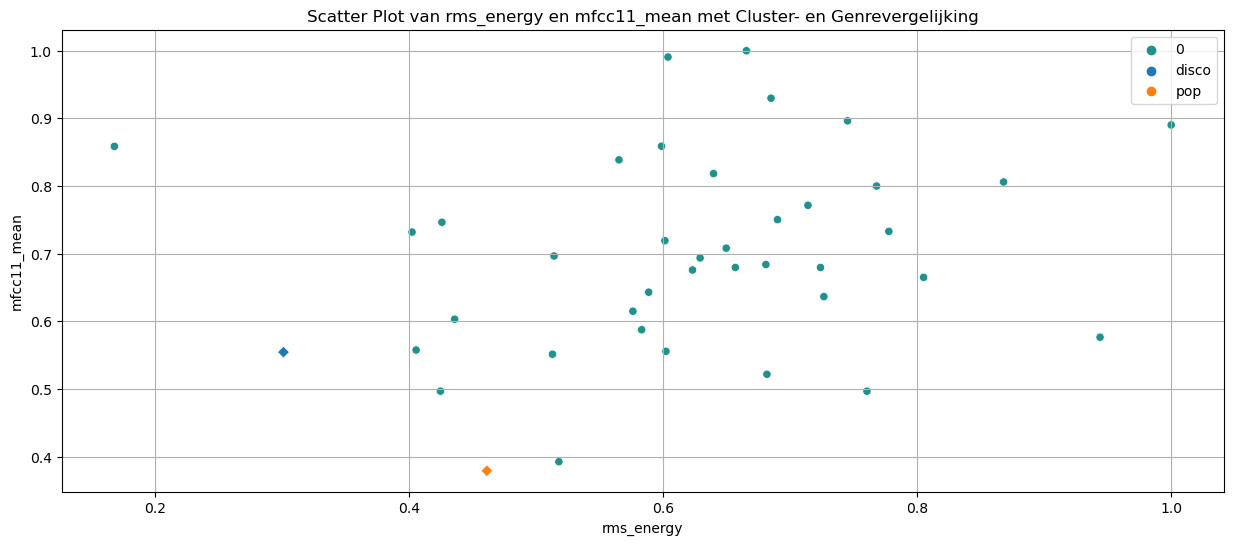

In [21]:
clusters = [0]

genres = ['disco', 'pop']


x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)


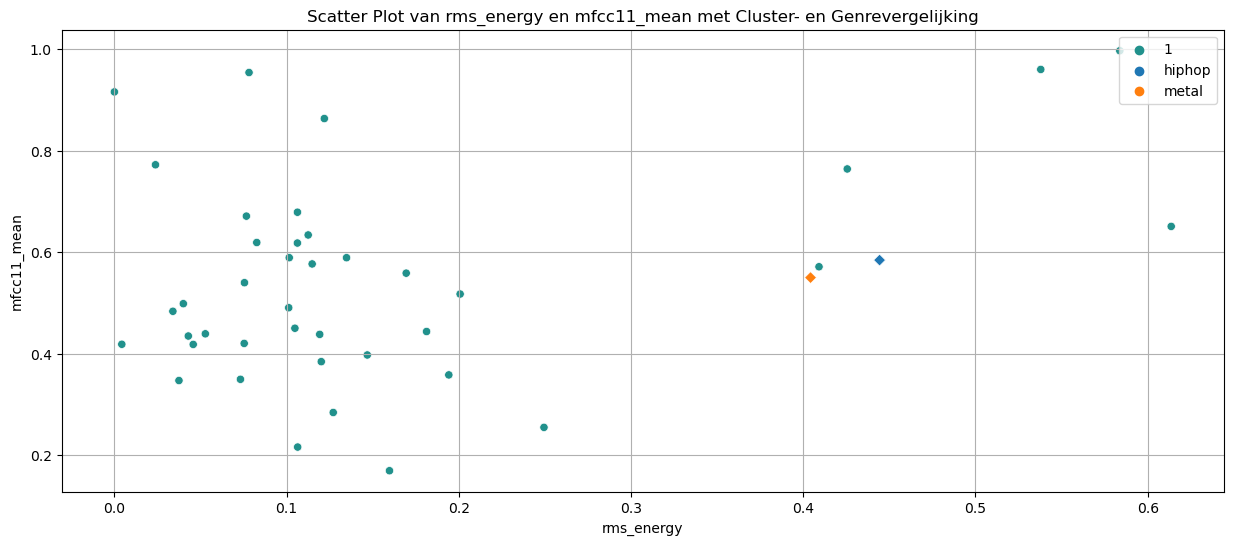

In [22]:
clusters = [1]

genres = ['metal', 'hiphop']

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

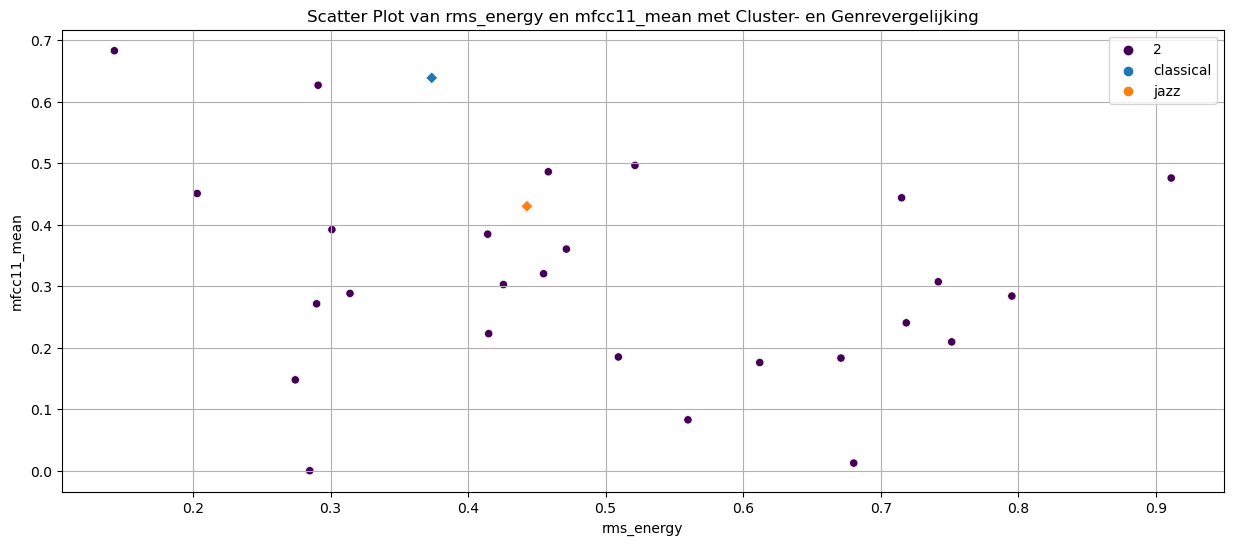

In [23]:
clusters = [2]

genres = ['jazz', 'classical']

x = 'rms_energy'
y = 'mfcc11_mean'

plot_vis(
    data1=unlabeled_data[unlabeled_data['cluster'].isin(clusters)],
    data2=label_scaled[label_scaled['genre'].isin(genres)],
    x=x,
    y=y
)

<a name="33-principal-component-analysis"></a> 
## 3.3: Principal Component Analysis

# PCA Voorbeeld

Om een voorbeeld te geven van het uitvoeren van PCA hebben we eerst een dataset nodig. Voor het gemak maken wij gebruik van een kleine zelf verzonnen dataset.
|       |   X1   |   X2   |
|-------|:-----:|:-----:|
|   1   |   4   |   1   |
|   2   |   2   |   3   |
|   3   |   7   |   6   |
|   4   |   5   |   4   |
|   5   |   9   |   8   |


## Stap 1: Standaardiseren

De eerste stap voor het uitvoeren van PCA is het standaardiseren van de bovenstaande dataset. Dit doen wij aan de hand van de formule voor de Z-score. $$
Z = \frac{{X - \mu}}{{\sigma}}
$$

Door het toepassen van de Z-score krijgen wij de volgende gestandaardiseerde dataset:

|   | xz1  | xz2  |
|---|---------|---------|
| 1 | -0.6325 | -1.2649 |
| 2 | -1.2649 | 0       |
| 3 | 0.6325  | 0.6325  |
| 4 | 0       | -0.6325 |
| 5 | 1.8974  | 1.2649  |


## Stap 2: Covariantiematrix
Vervolgen bereken wij de covariantie matrix van de gestandaardiseerde dataset. Dit doen wij aan de hand van de volgende formule:

$$
Cov(X_i, X_j) = \frac{\sum_{k=1}^{n}(X_i^k - \bar{X_i})(X_j^k - \bar{X_j})}{n-1}
$$

Wanneer wij de bovenstaande formule toepassen krijgen wij het volgende matrix:

\begin{bmatrix} 6.75 & 0.5 \\ 0.5 & 5.0 \end{bmatrix}






## Stap 3: Eigenwaarden en Eigenvectoren
In stap 3 berekenen wij de eigenwaarden en eigenvectoren.

Eigenwaarden:
\begin{align*}
\lambda_1 &= 1.9 \\
\lambda_2 &= 0.8
\end{align*}



Eigenvectoren:
\begin{align*}
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} \quad (\text{bij } \lambda_1) \\
v_2 &= \begin{bmatrix} -0.54 \\
0.84 \end{bmatrix} \quad (\text{bij } \lambda_2)
\end{align*}


## Stap 4: Feature vector
Wanneer we kijken naar stap 3 zien we dat vector 1 de meeste significantie heeft, dit is dus de vector met de hoogste eigenwaarde. We selecteren daarom v1 als ons eerst principal component. 
v_1 &= \begin{bmatrix} 0.84 \\ 
0.54 \end{bmatrix} 


## Stap 5: Projectie
Voor stap 5 gaan we de gestandaardiseerde gegevens vermenigvuldigen met de gekozen feature vector. Vervolgens krijgen de nieuwe dataset:
$$[-0.6325, -1.2649, -1.2649, 0.6325, 0.6325] \cdot [0.84, 0.54] = [-1.6326, -1.2649, -0.0810, 2.6305] $$
Zo komen wij tot een nieuwe dataset die is gereduceerd tot één dimensie, de eerste principale component.

|                       | Nieuwe Dataset |
|-----------------------|-----------------|
|           1           |     -1.6326     |
|           2           |     -1.2649     |
|           3           |     -0.0810     |
|           4           |      2.6305     |





Voor het uitvoeren van een simpele PCA hebben wij de stappen gevolgd die beschreven staan in het volgende artikel. (Jaadi, 2023) 

Nu dat wij een voorbeeld hebben gegeven van een simpele principal componenent analyse gaan wij dit nu uitvoeren op onze eigen dataset.


In [24]:


# Stap 1: Standaardiseren
#De data is eerder al gestandaardiseerd. Deze data kunnen we hier hergebruiken
scaled_df = data

In [25]:
# Stap 2: Covariantiematrix
# We maken een covariantiematrix aan de hand van no.cov
cov_matrix = np.cov(scaled_df, rowvar=False)

In [26]:
# Stap 3: Eigenwaarden en Eigenvectoren
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Nu sorteren wij de waardes
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]


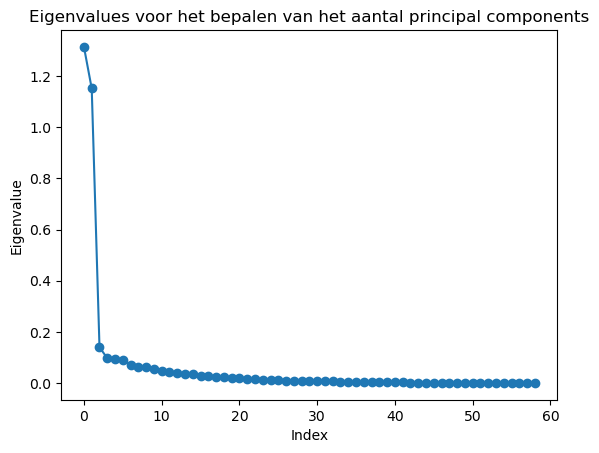

In [27]:
# Aantal principal compponents kiezen
plt.plot(eigenvalues, marker='o')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues voor het bepalen van het aantal principal components')
plt.show()


In [28]:
# Stap 4: Feature vector
pca_num = 3
principal_components = eigenvectors[:, -pca_num:]




In [29]:
# Stap 5: Projectie
pca = PCA(n_components=pca_num)
data_pca = pca.fit_transform(scaled_df)


In [30]:
# Resultaten toevoegen aan dataframe
unlabeld_new = unlabeled_data.copy()
for i in range(pca_num):
    unlabeld_new[f'PC{i+1}'] = data_pca[:, i]

In [31]:
# Toon het resultaat
display(unlabeled_data.head())


,bandwith,centroid,chromagram10_mean,chromagram11_mean,chromagram12_mean,chromagram1_mean,chromagram2_mean,chromagram3_mean,chromagram4_mean,chromagram5_mean,...,spectral_flatness,spectral_rolloff,tonnetz1_mean,tonnetz2_mean,tonnetz3_mean,tonnetz4_mean,tonnetz5_mean,tonnetz6_mean,zcr,cluster
0,0.448700,0.463313,0.536488,0.723331,0.959317,0.760275,0.628028,0.688307,0.598168,0.561027,...,0.075079,0.446538,0.601636,0.327193,0.433945,0.462291,0.286771,0.359017,0.485893,2
1,0.531218,0.660143,0.431423,0.385958,0.370729,0.728339,0.920078,0.984592,0.734350,0.421036,...,0.220823,0.583361,0.565916,0.462638,0.419674,0.263680,0.141557,0.452145,0.803681,2
2,0.370122,0.372563,0.584292,0.383882,0.094401,0.600906,0.101713,0.107339,0.045195,0.394422,...,0.017305,0.366321,0.539972,0.673517,0.074136,0.513645,0.213762,0.537025,0.504171,1
3,0.449617,0.502558,0.360861,0.606008,0.721541,0.650086,0.515102,0.610834,0.835636,1.000000,...,0.073118,0.473765,0.552052,0.282639,0.611838,0.573084,0.650816,0.246407,0.518485,2
4,0.000000,0.022579,0.115212,0.573531,0.077500,0.000000,0.021968,0.402056,0.456909,0.020207,...,0.000000,0.016254,0.234122,0.581224,0.558948,0.000000,0.204898,0.412068,0.112807,1


In [32]:
#PCA toevoegen aan dataset
df_pca = scaled_df.copy()
for i in range(pca_num):
    df_pca[f'PC{i+1}'] = data_pca[:, i]

In [33]:
pca_df = df_pca[['PC1', 'PC2', 'PC3']]


In [34]:
#Getransformeerde dataset
display(pca_df.head())

,PC1,PC2,PC3
0,1.836866,-0.018816,0.010516
1,1.996875,0.314686,0.013659
2,0.181995,-1.041242,1.209566
3,1.909274,0.041188,-0.277533
4,-0.783876,-1.630182,-0.864740


<a name="34-non-negative-matrix-factorization"></a> 
## 3.4: Non-negative matrix factorization

In [35]:
#Hier komt alles wat met NMF te maken heeft

 <a name="35-dimensionality-reduction"></a> 
 ## 3.5: Dimensionality Reduction


<a name="36-aanbevelingsapp"></a> 
## 3.6: Aanbevelingsapp

<a name="hoofdstuk-4-bevindingen-en-conclusie"></a>
# Hoofdstuk 4: Bevindingen en Conclusie

<a name="41-bevindingen"></a> 
## 4.1 Bevindingen

<a name="42-conclusie"></a> 
## 4.2 Conclusie

<a name="hoofdstuk-5-referentielijst"></a>
# Hoofdstuk 5: Referentielijst

- Deruty, E. (2022, 15 december). Intuitive understanding of MFCCs - Emmanuel Deruty - Medium. Medium. https://medium.com/@derutycsl/intuitive-understanding-of-mfccs-836d36a1f779

- Hathaway, R. B. (2005). TRANSDUCERS AND DATA ACQUISITION. In Elsevier eBooks (pp. 1–56). https://doi.org/10.1016/b978-075067719-6/50002-6

- librosa.feature.spectral_contrast — librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_contrast.html

- librosa.feature.tonnetz — librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html

- librosa.feature.spectral_rolloff — librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

- Wikipedia contributors. (2024b, februari 9). Chroma feature. Wikipedia. https://en.wikipedia.org/wiki/Chroma_feature

- Verma, Y. (2021, 11 november). A Tutorial on Spectral Feature Extraction for Audio Analytics. Analytics India Magazine. https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/

- Wikipedia contributors. (2023, 1 december). Spectral flatness. Wikipedia. https://en.wikipedia.org/wiki/Spectral_flatness

- Torres-García, A. A., Mendoza-Montoya, O., Molinas, M., Antelis, J. M., Moctezuma, L. A., & Hernández-Del-Toro, T. (2022). Pre-processing and feature extraction. In Elsevier eBooks (pp. 59–91). https://doi.org/10.1016/b978-0-12-820125-1.00014-2

- Wikipedia contributors. (2024a, januari 5). Centroid. Wikipedia. https://en.wikipedia.org/wiki/Centroid



- Wikipedia-bijdragers. (2023, 31 juli). Hoofdcomponentenanalyse. Wikipedia. Geraadpleegd op 21-1-2024 van https://nl.wikipedia.org/wiki/Hoofdcomponentenanalyse 

- Jaadi, Z. (2023, 29 maart). A Step-by-Step Explanation of Principal Component Analysis (PCA). Built In. Geraadpleegd op 21-1-2024 van https://builtin.com/data-science/step-step-explanation-principal-component-analysis
- Beat and Tempo — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/beat.html

- Filters — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/filters.html#filter-bank-construction

- Librosa.feature.spectral_centroid — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_centroid.html

- Librosa.feature.spectral_bandwidth — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_bandwidth.html

- Librosa.feature.spectral_flatness — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.spectral_flatness.html

- Librosa.feature.zero_crossing_rate — Librosa 0.10.1 Documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.zero_crossing_rate.html

- Librosa.feature.Tempogram — Librosa 0.10.1 documentation. (z.d.). https://librosa.org/doc/latest/generated/librosa.feature.tempogram.html

- Scipy.spatial.distance.cityblock — SciPY v1.12.0 Manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cityblock.html

- Scipy.spatial.distance.euclidean — SciPY v1.12.0 manual. (z.d.). https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.euclidean.html